In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from torch.utils.data import Dataset, DataLoader
from IPython.display import HTML
from IPython.display import display, clear_output

from data_funcs_and_classes import AnimatedScatter, generate_data, UMIDataset, generate_random_data
from model_classes import UMINN

In [2]:
n_clusters = 2

data, labels = generate_random_data(n_clusters)

loader = DataLoader(UMIDataset(torch.from_numpy(data), torch.from_numpy(labels)), batch_size=32, shuffle=True)

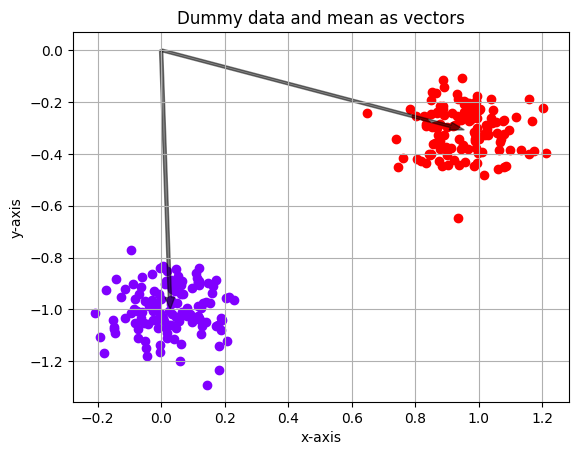

In [3]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

#colors = ['red','green','blue','orange', 'purple', ]
#colors = colors[:n_clusters]

colors = cm.rainbow(np.linspace(0, 1, n_clusters))
means = np.mean(np.reshape(data,(n_clusters, int(data.shape[0]/n_clusters), data.shape[-1])), axis = 1)
cluster_N = int(data.shape[0] / n_clusters)
for color,mean,i in zip(colors, means, range(len(colors))):
    ax.scatter(data[i*cluster_N:(i+1)*cluster_N,0],data[i*cluster_N:(i+1)*cluster_N,1],color=color)
    ax.arrow(0,0,mean[0],mean[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))
plt.title('Dummy data and mean as vectors')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.grid('on')

In [4]:
def train(dl, model, lr = 0.01, n_epochs = 2):
    losses = []
    epochs = []
    weights = []
    
    for epoch in range(n_epochs):
        #print(f"Epoch {epoch}")
        N = len(loader)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(loader):
            epochs.append(epoch + i/N)
            loss_data = model.train_step(data, labels)
            losses.append(loss_data)
    return losses, epochs, weights
            

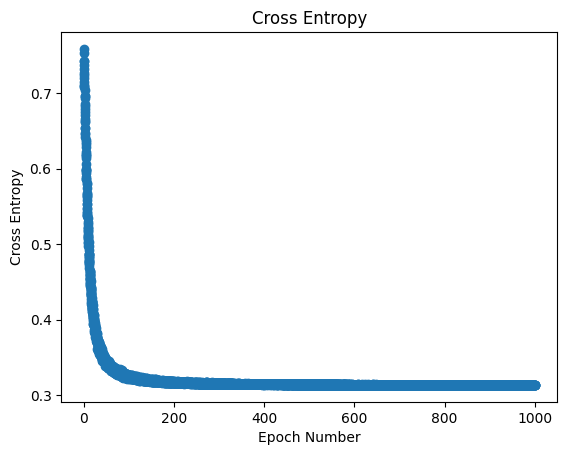

In [5]:
model = UMINN(out_size = n_clusters)
lr = 0.001
n_epochs = 1000
losses, epochs, weights = train(loader, model, lr, n_epochs)

plt.plot(epochs, losses, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
_ = plt.title('Cross Entropy')

In [6]:
print(weights[-1])

[[-7.434014  -5.290017 ]
 [ 6.604794   5.1974745]]


In [7]:
def plot_area(weights):
    
    e1 = torch.tensor([0., 1.])
    e2 = torch.tensor([1., 0.])
    for weight in weights:
        # Plot unit vectors
        for vec in [e1, e2]:
            plt.arrow(0, 0, vec[0], vec[1], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
        w_e1 = w*e1
        w_e2 = w*e2
        plt.arrow(0, 0, w_e1[0][1], w_e1[1][1], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
        plt.arrow(0, 0, w_e2[0][0], w_e2[1][0], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
        x = [0, w_e1[0][1], w_e2[0][0]]
        y = [0, w_e1[1][1], w_e2[1][0]]
        plt.fill(x, y)
        plt.pause(0.01)
    plt.show()
    return None

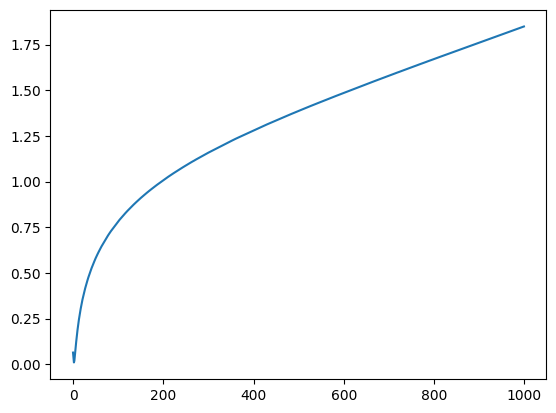

In [8]:
e1 = torch.tensor([0., 1.])
e2 = torch.tensor([1., 0.])
area = [torch.linalg.norm(torch.linalg.cross(torch.tensor([(torch.tensor(weight)*e1)[0][1], (torch.tensor(weight)*e1)[1][1], 0]), torch.tensor([(torch.tensor(weight)*e2)[0][0], (torch.tensor(weight)*e2)[1][0], 0])))/2 for weight in weights]
plt.plot(np.arange(len(area)), area)

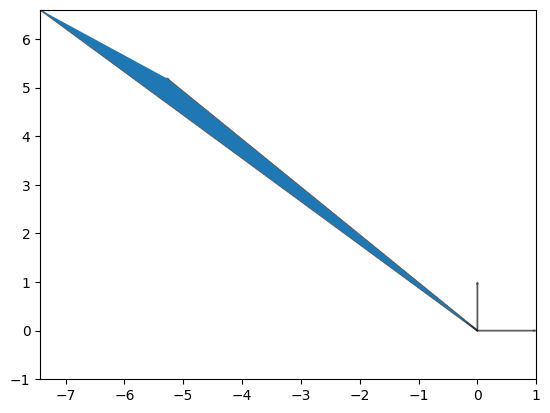

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

e1 = torch.tensor([0., 1.])
e2 = torch.tensor([1., 0.])
for weight in weights[::2]:
    ax.cla()
        # Plot unit vectors
    for vec in [e1, e2]:
        ax.arrow(0, 0, vec[0], vec[1], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
    w_e1 = torch.tensor(weight)*e1
    w_e2 = torch.tensor(weight)*e2
    #area = torch.linalg.norm(torch.linalg.cross(torch.tensor([w_e1[0][1], w_e1[1][1], 0]), torch.tensor([w_e2[0][0], w_e2[1][0], 0])))/2
   
    #plt.title(f"Area = {area}")
    ax.arrow(0, 0, w_e1[0][1], w_e1[1][1], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
    ax.arrow(0, 0, w_e2[0][0], w_e2[1][0], length_includes_head=True, width=0.01,color=(0,0,0,0.5))
    x = [0, w_e1[0][1], w_e2[0][0]]
    y = [0, w_e1[1][1], w_e2[1][0]]
    ax.fill(x, y)
    ax.set_xlim(min(-1, w_e1[0][1], w_e2[0][0]), max(1, w_e1[0][1], w_e2[0][0]))
    ax.set_ylim(min(-1, w_e1[1][1], w_e2[1][0]), max(1, w_e1[1][1], w_e2[1][0]))
    
    display(fig)
    
    clear_output(wait = True)
    
    plt.pause(0.01)
    plt.show()

In [10]:
#_ = plot_area(weights)

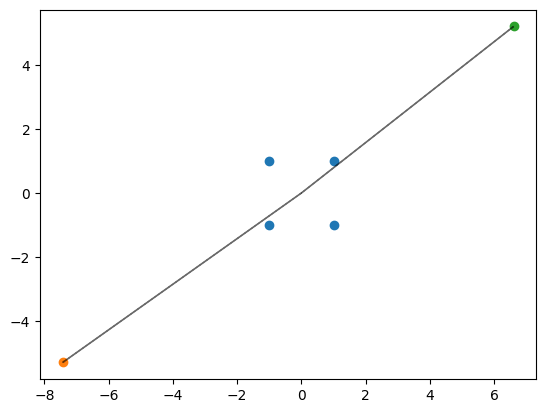

In [11]:
plt.scatter([-1, -1, 1, 1], [1, -1, 1, -1])
for point in weights[-1]:
    plt.scatter(point[0], point[1])
    plt.arrow(0, 0, point[0], point[1], length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [12]:
test_data, test_labels = generate_data()
#print(model(torch.tensor(test_data)).argmax(dim=1))
#print(torch.tensor(test_labels))
acc = (model(torch.tensor(test_data)).argmax(dim=1) == torch.tensor(test_labels)).float().sum().item()/len(test_labels)
print(acc)

0.00390625


In [14]:
# epoch_data_avgd = np.array(epochs).reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
# loss_data_avgd = np.array(losses).reshape(100,-1).mean(axis=1)

# plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

# crossloss_data_avgd = np.array(model.cross_losses[:]).reshape(100,-1).mean(axis=1)
# jacobiloss_data_avgd = np.array(model.jacobi_losses[:]).reshape(100,-1).mean(axis=1)
# plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
# plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch
# # plt.plot(epoch_data,loss_data)


# plt.legend()

In [16]:
# animated_scatter = AnimatedScatter(data, np.array(weights).transpose([0, 2, 1]), losses[::16], n_clusters = n_clusters, acc = acc)
# html_object = HTML(animated_scatter.animation.to_html5_video())
# html_object